# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [ ]:
!pip install openpyxl

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import shutil
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
# Import your chosen baseline model
# Example: from sklearn.linear_model import LogisticRegression


## Load dataset
Load preprocessed dataset and print basic details.

### Directory preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

# Replace 'path/to/your/zipped_folder.zip' with the actual path to your zipped folder in Google Drive.
zip_path = '/content/drive/MyDrive/opencampus_all_files/Rider1_preprocessed.zip'

# Extract the contents of the zip file to a specified directory.
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/Rider1_preprocessed')
print(f"Successfully unzipped {zip_path} to /content/unzipped_folder")


Successfully unzipped /content/drive/MyDrive/opencampus_all_files/Rider1_preprocessed.zip to /content/unzipped_folder


In [4]:
source_dir = '/content/Rider1_preprocessed/content/content/Sport_xlsx/Rider1_preprocessed'
destination_dir = '/content/Rider1_preprocessed'

# Iterate through all files in the source directory
for filename in os.listdir(source_dir):
    source_path = os.path.join(source_dir, filename)
    destination_path = os.path.join(destination_dir, filename)

    # Check if it's a file (not a subdirectory)
    if os.path.isfile(source_path):
        # Move the file
        shutil.move(source_path, destination_path)

In [5]:
# Define the directory to clean
directory_to_clean = '/content/Rider1_preprocessed'

# Check if the directory exists
if os.path.exists(directory_to_clean):
    for filename in os.listdir(directory_to_clean):
        filepath = os.path.join(directory_to_clean, filename)
        try:
            if os.path.isdir(filepath):
                shutil.rmtree(filepath)  # Remove folders recursively
                print(f"Removed directory: {filepath}")
        except OSError as e:
            print(f"Error removing {filepath}: {e}")
else:
    print(f"Directory '{directory_to_clean}' not found.")

Removed directory: /content/Rider1_preprocessed/content


### Explore dataset

In [12]:
# Load example file
df = pd.read_excel('/content/Rider1_preprocessed/f1.xlsx')

# Show features
df.head()

,Latitude,Longitude,Elevation,Time,Distance
0,46.363649,14.112036,511.5,0,0.000000
1,46.363691,14.112026,511.0,1,4.731651
2,46.363778,14.112031,510.1,3,14.410085
3,46.363835,14.112023,509.7,5,20.775954
4,46.363888,14.112007,509.4,7,26.794638


In [13]:
# Print the range of all columns in the DataFrame
for col in df.columns:
    print(f"Column '{col}': Min = {df[col].min()}, Max = {df[col].max()}")

Column 'Latitude': Min = 46.338096, Max = 46.422636
Column 'Longitude': Min = 13.919303, Max = 14.112036
Column 'Elevation': Min = 480.8, Max = 1659.9
Column 'Time': Min = 0, Max = 20896
Column 'Distance': Min = 0.0, Max = 61367.54987900978


## Model Choice

[Explain why you've chosen a particular model as the baseline. This could be a simple statistical model or a basic machine learning model. Justify your choice.]


## Feature engineering

In [14]:
# Assuming 'df' is your DataFrame as defined in the previous code.
df['Latitude_prev'] = df['Latitude'].shift(1)
df['Longitude_prev'] = df['Longitude'].shift(1)
df['Elevation_prev'] = df['Elevation'].shift(1)
df['Latitude_next'] = df['Latitude'].shift(-1)
df['Longitude_next'] = df['Longitude'].shift(-1)
df['Elevation_next'] = df['Elevation'].shift(-1)

# Calculate speed based on distance and time differences
df['Time_prev'] = df['Time'].shift(1)
df['Time_next'] = df['Time'].shift(-1)
df['Distance_prev'] = df['Distance'].shift(1)
df['Distance_next'] = df['Distance'].shift(-1)

# Calculate time difference
df['Time_diff_prev'] = df['Time'] - df['Time_prev']
df['Time_diff_next'] = df['Time_next'] - df['Time']

# Calculate distance difference
df['Distance_diff_prev'] = df['Distance'] - df['Distance_prev']
df['Distance_diff_next'] = df['Distance_next'] - df['Distance']

# Calculate speed (m/s)
df['Speed'] = (df['Distance_diff_next'] + df['Distance_diff_prev']) / (df['Time_diff_next'] + df['Time_diff_prev'])

# Calculate the total elevation gain
df['Elevation_diff'] = df['Elevation'] - df['Elevation_prev']
df['total_elev_gain'] = df['Elevation_diff'].cumsum()

# Replace negative elevation differences with 0
df['total_elev_gain'] = df['total_elev_gain'].clip(lower=0)

# Drop additional columns
df = df.drop(['Time_prev', 'Time_next', 'Distance_prev', 'Distance_next', 'Time_diff_prev', 'Time_diff_next', 'Distance_diff_prev', 'Distance_diff_next',
              'Elevation_diff'], axis=1)

print(df.head())

    Latitude  Longitude  Elevation  Time   Distance  Latitude_prev  \
0  46.363649  14.112036      511.5     0   0.000000            NaN   
1  46.363691  14.112026      511.0     1   4.731651      46.363649   
2  46.363778  14.112031      510.1     3  14.410085      46.363691   
3  46.363835  14.112023      509.7     5  20.775954      46.363778   
4  46.363888  14.112007      509.4     7  26.794638      46.363835   

   Longitude_prev  Elevation_prev  Latitude_next  Longitude_next  \
0             NaN             NaN      46.363691       14.112026   
1       14.112036           511.5      46.363778       14.112031   
2       14.112026           511.0      46.363835       14.112023   
3       14.112031           510.1      46.363888       14.112007   
4       14.112023           509.7      46.363943       14.111994   

   Elevation_next     Speed  total_elev_gain  
0           511.0       NaN              NaN  
1           510.1  4.803362              0.0  
2           509.7  4.011076  

In [15]:
def move_random_files(source_dir, destination_dir, num_files):
    # Get a list of all files in the source directory
    files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

    # Check if there are enough files to move
    if len(files) < num_files:
        print(f"Not enough files in {source_dir}. Moving {len(files)} files.")
        num_files = len(files)

    # Randomly select files
    selected_files = random.sample(files, num_files)

    # Move the selected files to the destination directory
    for file in selected_files:
        source_path = os.path.join(source_dir, file)
        destination_path = os.path.join(destination_dir, file)
        try:
            shutil.move(source_path, destination_path)
            print(f"Moved {file} to {destination_dir}")
        except Exception as e:
            print(f"Error moving {file}: {e}")

# Example usage
source_directory = '/content/Rider1_preprocessed'
destination_directory = '/content/Rider1_test'
number_of_files = 10

# Create destination directory if it does not exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

move_random_files(source_directory, destination_directory, number_of_files)

Moved f81.xlsx to /content/Rider1_test
Moved f492.xlsx to /content/Rider1_test
Moved f556.xlsx to /content/Rider1_test
Moved f747.xlsx to /content/Rider1_test
Moved f681.xlsx to /content/Rider1_test
Moved f411.xlsx to /content/Rider1_test
Moved f238.xlsx to /content/Rider1_test
Moved f86.xlsx to /content/Rider1_test
Moved f2.xlsx to /content/Rider1_test
Moved f41.xlsx to /content/Rider1_test


In [16]:
# Directory containing the Excel files
directory = '/content/Rider1_preprocessed'

# Initialize an empty list to store DataFrames
dataframes = []

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.xlsx'):  # Process only .xlsx files
        filepath = os.path.join(directory, filename)

        # Read the Excel file into a DataFrame
        df = pd.read_excel(filepath)

        # Apply preprocessing
        df['Latitude_prev'] = df['Latitude'].shift(1)
        df['Longitude_prev'] = df['Longitude'].shift(1)
        df['Elevation_prev'] = df['Elevation'].shift(1)
        df['Latitude_next'] = df['Latitude'].shift(-1)
        df['Longitude_next'] = df['Longitude'].shift(-1)
        df['Elevation_next'] = df['Elevation'].shift(-1)

        df['Time_prev'] = df['Time'].shift(1)
        df['Time_next'] = df['Time'].shift(-1)
        df['Distance_prev'] = df['Distance'].shift(1)
        df['Distance_next'] = df['Distance'].shift(-1)

        df['Time_diff_prev'] = df['Time'] - df['Time_prev']
        df['Time_diff_next'] = df['Time_next'] - df['Time']

        df['Distance_diff_prev'] = df['Distance'] - df['Distance_prev']
        df['Distance_diff_next'] = df['Distance_next'] - df['Distance']

        df['Speed'] = (df['Distance_diff_next'] + df['Distance_diff_prev']) / (df['Time_diff_next'] + df['Time_diff_prev'])

        df['Elevation_diff'] = df['Elevation'] - df['Elevation_prev']
        df['total_elev_gain'] = df['Elevation_diff'].cumsum()
        df['total_elev_gain'] = df['total_elev_gain'].clip(lower=0)

        df = df.drop(['Time_prev', 'Time_next', 'Distance_prev', 'Distance_next', 'Time_diff_prev', 'Time_diff_next',
                      'Distance_diff_prev', 'Distance_diff_next', 'Elevation_diff'], axis=1)

        # Drop NaN values
        df.dropna(inplace=True)

        # Append the processed DataFrame to the list
        dataframes.append(df)

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(combined_df.head())

# Save the combined DataFrame to a file (optional)
combined_df.to_csv('/content/combined_data.csv', index=False)


    Latitude  Longitude  Elevation  Time   Distance  Latitude_prev  \
0  46.142038  15.035406      217.0     4  25.130109      46.142250   
1  46.141942  15.035371      217.0     5  36.138238      46.142038   
2  46.141879  15.035354      217.0     6  43.263069      46.141942   
3  46.141818  15.035340      217.0     7  50.129212      46.141879   
4  46.141756  15.035328      217.0     8  57.082857      46.141818   

   Longitude_prev  Elevation_prev  Latitude_next  Longitude_next  \
0       15.035519           217.0      46.141942       15.035371   
1       15.035406           217.0      46.141879       15.035354   
2       15.035371           217.0      46.141818       15.035340   
3       15.035354           217.0      46.141756       15.035328   
4       15.035340           217.0      46.141696       15.035317   

   Elevation_next     Speed  total_elev_gain  
0           217.0  7.227648              0.0  
1           217.0  9.066480              0.0  
2           217.0  6.995487  

## Feature Selection

[Indicate which features from the dataset you will be using for the baseline model, and justify your selection.]


In [17]:
# Load the dataset
# Replace 'your_dataset.csv' with the path to your actual dataset
df = pd.read_csv('/content/combined_data.csv')

# Feature selection
# Example: Selecting only two features for a simple baseline model
X = df[['Latitude', 'Longitude', 'Elevation', 'Latitude_prev', 'Longitude_prev', 'Elevation_prev', 'Latitude_next', 'Longitude_next', 'Elevation_next', 'Distance', 'total_elev_gain']] # Add elevation_prev and elevation_next
y = df['Speed']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# Size of datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (3613878, 11)
X_test shape: (903470, 11)
y_train shape: (3613878,)
y_test shape: (903470,)


## Implementation

[Implement your baseline model here.]



#### Baseline model 1 - Linear Regression

In [28]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 15.843865942382164


#### Baseline model 2 - Simple Neural Network

Epoch 1/10
112934/112934 [==============================] - 205s 2ms/step - loss: 12.7232 - mae: 2.4976 - val_loss: 11.5415 - val_mae: 2.3831
Epoch 2/10
112934/112934 [==============================] - 203s 2ms/step - loss: 11.2358 - mae: 2.2980 - val_loss: 10.2172 - val_mae: 2.1564
Epoch 3/10
112934/112934 [==============================] - 204s 2ms/step - loss: 10.3560 - mae: 2.1570 - val_loss: 9.7764 - val_mae: 2.0944
Epoch 4/10
112934/112934 [==============================] - 197s 2ms/step - loss: 9.6820 - mae: 2.0742 - val_loss: 8.9182 - val_mae: 2.0069
Epoch 5/10
112934/112934 [==============================] - 202s 2ms/step - loss: 9.2629 - mae: 2.0201 - val_loss: 8.6057 - val_mae: 1.9431
Epoch 6/10
112934/112934 [==============================] - 201s 2ms/step - loss: 9.0418 - mae: 1.9884 - val_loss: 8.6456 - val_mae: 1.9577
Epoch 7/10
112934/112934 [==============================] - 201s 2ms/step - loss: 8.8892 - mae: 1.9690 - val_loss: 8.3290 - val_mae: 1.9088
Epoch 8/10
1129

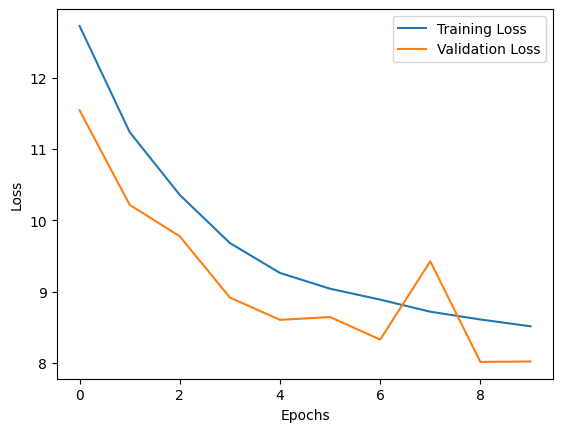

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),  # First hidden layer
    Dense(32, activation='relu'),  # Second hidden layer
    Dense(1)  # Output layer (no activation since we're doing regression)
])

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Optionally, plot the training history (e.g., loss or MAE over epochs)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation

[Clearly state what metrics you will use to evaluate the model's performance. These metrics will serve as a starting point for evaluating more complex models later on.]



In [71]:
# Prepare test file
df = pd.read_excel('/content/Rider1_test/f681.xlsx')

# Assuming 'df' is your DataFrame as defined in the previous code.
df['Latitude_prev'] = df['Latitude'].shift(1)
df['Longitude_prev'] = df['Longitude'].shift(1)
df['Elevation_prev'] = df['Elevation'].shift(1)
df['Latitude_next'] = df['Latitude'].shift(-1)
df['Longitude_next'] = df['Longitude'].shift(-1)
df['Elevation_next'] = df['Elevation'].shift(-1)

# Calculate speed based on distance and time differences
df['Time_prev'] = df['Time'].shift(1)
df['Time_next'] = df['Time'].shift(-1)
df['Distance_prev'] = df['Distance'].shift(1)
df['Distance_next'] = df['Distance'].shift(-1)

# Calculate time difference
df['Time_diff_prev'] = df['Time'] - df['Time_prev']
df['Time_diff_next'] = df['Time_next'] - df['Time']

# Calculate distance difference
df['Distance_diff_prev'] = df['Distance'] - df['Distance_prev']
df['Distance_diff_next'] = df['Distance_next'] - df['Distance']

# Calculate speed (m/s)
df['Speed'] = (df['Distance_diff_next'] + df['Distance_diff_prev']) / (df['Time_diff_next'] + df['Time_diff_prev'])

# Calculate the total elevation gain
df['Elevation_diff'] = df['Elevation'] - df['Elevation_prev']
df['total_elev_gain'] = df['Elevation_diff'].cumsum()

# Replace negative elevation differences with 0
df['total_elev_gain'] = df['total_elev_gain'].clip(lower=0)

# Drop additional columns
df = df.drop(['Time_prev', 'Time_next', 'Distance_prev', 'Distance_next', 'Time_diff_prev', 'Time_diff_next', 'Distance_diff_prev', 'Distance_diff_next',
              'Elevation_diff'], axis=1)

df.dropna(inplace=True)

print(df.head())

     Latitude  Longitude  Elevation  Time   Distance  Latitude_prev  \
11  46.078104  14.825900      243.0     0   0.000000      46.078104   
12  46.077981  14.825824      243.0     2  14.882201      46.078104   
13  46.077912  14.825778      243.0     4  23.336991      46.077981   
14  46.077752  14.825673      243.0     6  42.888397      46.077912   
15  46.077685  14.825635      243.0     7  50.894766      46.077752   

    Longitude_prev  Elevation_prev  Latitude_next  Longitude_next  \
11       14.825900           243.0      46.077981       14.825824   
12       14.825900           243.0      46.077912       14.825778   
13       14.825824           243.0      46.077752       14.825673   
14       14.825778           243.0      46.077685       14.825635   
15       14.825673           243.0      46.077649       14.825615   

    Elevation_next     Speed  total_elev_gain  
11           243.0  7.441100              0.0  
12           243.0  5.834248              0.0  
13           2

In [72]:
# Feature selection
# Example: Selecting only two features for a simple baseline model
X = df[['Latitude', 'Longitude', 'Elevation', 'Latitude_prev', 'Longitude_prev', 'Elevation_prev', 'Latitude_next', 'Longitude_next', 'Elevation_next', 'Distance', 'total_elev_gain']]
y = df['Speed']


In [73]:
# Normalize the new data using the same scaler fitted on the training data
X_new_scaled = scaler.transform(X)

# Make predictions on the new data
y_pred = model.predict(X_new_scaled)

# Add the predicted values as a new column 'Speed_pred' in the original DataFrame
df['Speed_pred'] = y_pred

# Optionally, check the first few rows to verify the new column is added correctly
print(df.head())


 95/314 [========>.....................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


314/314 [==============================] - 0s 1ms/step
     Latitude  Longitude  Elevation  Time   Distance  Latitude_prev  \
11  46.078104  14.825900      243.0     0   0.000000      46.078104   
12  46.077981  14.825824      243.0     2  14.882201      46.078104   
13  46.077912  14.825778      243.0     4  23.336991      46.077981   
14  46.077752  14.825673      243.0     6  42.888397      46.077912   
15  46.077685  14.825635      243.0     7  50.894766      46.077752   

    Longitude_prev  Elevation_prev  Latitude_next  Longitude_next  \
11       14.825900           243.0      46.077981       14.825824   
12       14.825900           243.0      46.077912       14.825778   
13       14.825824           243.0      46.077752       14.825673   
14       14.825778           243.0      46.077685       14.825635   
15       14.825673           243.0      46.077649       14.825615   

    Elevation_next     Speed  total_elev_gain  Speed_pred  
11           243.0  7.441100              0

In [74]:
df.head()

,Latitude,Longitude,Elevation,Time,Distance,Latitude_prev,Longitude_prev,Elevation_prev,Latitude_next,Longitude_next,Elevation_next,Speed,total_elev_gain,Speed_pred
11,46.078104,14.825900,243.0,0,0.000000,46.078104,14.825900,243.0,46.077981,14.825824,243.0,7.441100,0.0,-180.901154
12,46.077981,14.825824,243.0,2,14.882201,46.078104,14.825900,243.0,46.077912,14.825778,243.0,5.834248,0.0,-438.684418
13,46.077912,14.825778,243.0,4,23.336991,46.077981,14.825824,243.0,46.077752,14.825673,243.0,7.001549,0.0,-589.789307
14,46.077752,14.825673,243.0,6,42.888397,46.077912,14.825778,243.0,46.077685,14.825635,243.0,9.185925,0.0,-802.376953
15,46.077685,14.825635,243.0,7,50.894766,46.077752,14.825673,243.0,46.077649,14.825615,243.0,6.148267,0.0,-843.819092


In [55]:
print(X_train_scaled[0])
print(X_new_scaled[0])


[-0.10022477  0.4059342   0.01058208 -0.0998529   0.40590383  0.01059362
 -0.10059642  0.4059664   0.00890817 -0.86383038 -0.66657351]
[ 4.60782740e+01  1.48260820e+01  2.68200000e+02  4.60782430e+01
  1.48260530e+01  2.68200000e+02  4.60783120e+01  1.48261190e+01
  2.68200000e+02  4.11161244e+00 -1.53084463e-17]


### Evaluate track length in seconds
Example code

In [31]:
import pandas as pd
import numpy as np

# Data
data = {
    'Speed': [np.nan, 4.606892, 5.372097, 6.147122, 6.584172],
    'Distance': [0.0, 4.111612, 9.213784, 14.855806, 21.508028]
}
df = pd.DataFrame(data)

# Initialize Time column
df['Time'] = 0.0

# Compute Time intelligently
for i in range(1, len(df)):
    if pd.notna(df.loc[i, 'Speed']):
        df.loc[i, 'Time'] = df.loc[i - 1, 'Time'] + (df.loc[i, 'Distance'] - df.loc[i - 1, 'Distance']) / df.loc[i, 'Speed']

print(df)

      Speed   Distance      Time
0       NaN   0.000000  0.000000
1  4.606892   4.111612  0.892492
2  5.372097   9.213784  1.842246
3  6.147122  14.855806  2.760077
4  6.584172  21.508028  3.770413
